Scenario geladen: rirs/rirs_20260213_134008.pkl
INFO: Ruis-verwerking overgeslagen (geen bestanden of geen ruis-RIRs gevonden).
Succes!
Klaar! De bestanden 'output_clean_speech.wav' en 'output_mic_with_reverb.wav' staan in je map.


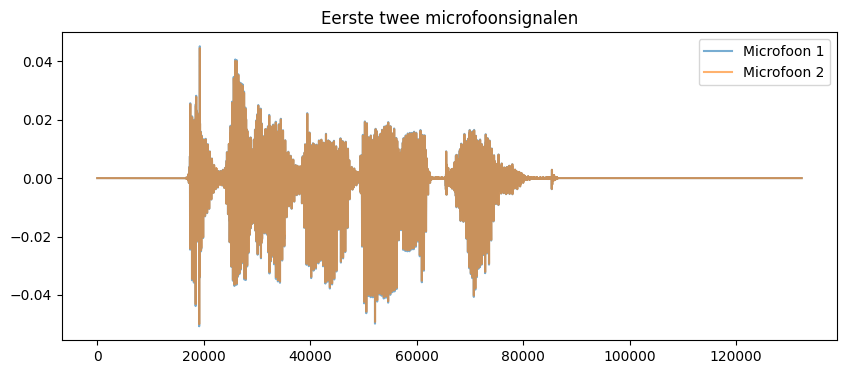

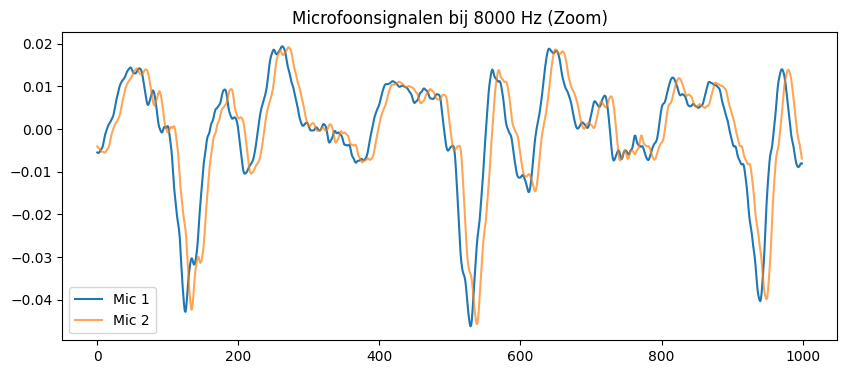

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import scipy.signal as signal
import os
from package import load_rirs, select_latest_rir

def create_micsigs(acoustic_scenario, speech_filenames, noise_filenames, duration):
    fs_rir = acoustic_scenario.fs
    num_mics = len(acoustic_scenario.RIRs_audio[0])
    num_samples = int(duration * fs_rir)
    
    speech_component = np.zeros((num_samples, num_mics))
    noise_component = np.zeros((num_samples, num_mics))

 

    for src_idx, filename in enumerate(speech_filenames):
        audio, fs_src = sf.read(filename)
        if fs_src != fs_rir:
            new_len = int(len(audio) * fs_rir / fs_src)
            audio = signal.resample(audio, new_len)
        
        for mic_idx in range(num_mics):
            rir = acoustic_scenario.RIRs_audio[:, mic_idx, src_idx]
            filtered = signal.fftconvolve(audio, rir, mode='full')
            
            #  EXTRA CHECK PLOT 
            #if src_idx == 0 and mic_idx == 0:
                #plt.figure(figsize=(10, 5))
                #plt.subplot(2, 1, 1)
                #plt.plot(audio[:fs_rir], color='blue')
                #plt.title("VOOR convolutie (Originele droge spraak - 1 sec)")
                #plt.subplot(2, 1, 2)
                #plt.plot(filtered[:fs_rir], color='red')
                #plt.title("NA convolutie (Met kamerakoestiek/galm - 1 sec)")
                #plt.tight_layout()
                #plt.show() 
            
            L = min(len(filtered), num_samples)
            speech_component[:L, mic_idx] += filtered[:L]

# RUIS 

    if noise_filenames and len(noise_filenames) > 0 and acoustic_scenario.RIRs_noise is not None:
        for src_idx, filename in enumerate(noise_filenames):
            if not filename: continue
            print(f" - Verwerken ruis: {filename}")
            audio, fs_src = sf.read(filename)
            
            if fs_src != fs_rir:
                audio = signal.resample(audio, int(len(audio) * fs_rir / fs_src))
                
            for mic_idx in range(num_mics):
  
                rir = acoustic_scenario.RIRs_noise[:, mic_idx, src_idx]
                filtered = signal.fftconvolve(audio, rir, mode='full')
                
                L = min(len(filtered), num_samples)
                noise_component[:L, mic_idx] += filtered[:L]
    else:
        print("INFO: Ruis-verwerking overgeslagen (geen bestanden of geen ruis-RIRs gevonden).")

    mic = speech_component + noise_component

  
    plt.figure(figsize=(10, 4))
    plt.plot(mic[:, 0], label="Microfoon 1", alpha=0.6)
    plt.plot(mic[:, 1], label="Microfoon 2", alpha=0.6)
    plt.title("Eerste twee microfoonsignalen")
    plt.legend()
    plt.savefig("part2_mic_signals.png") 
    
    return mic, speech_component, noise_component

if __name__== "__main__":
    
    
   
    speech_files = [os.path.join("sound_files", "speech1.wav")]
    noise_files = [os.path.join("sound_files", "Babble_noise1.wav")]
    
   
    try:
        path_to_rirs = "rirs"
        rir_file = select_latest_rir(path_to_rirs)
        acousticScenario = load_rirs(rir_file)
        print(f"Scenario geladen: {rir_file}")
    except Exception as e:
        print(f"FOUT bij laden RIR: {e}")
      
        exit()

 
    try:
        mics, speech, noise = create_micsigs(
            acoustic_scenario=acousticScenario,
            speech_filenames=speech_files,
            noise_filenames=noise_files,
            duration=3.0
        )
        print("Succes!")
    except Exception as e:
        print(f"FOUT tijdens uitvoeren functie: {e}")
        import traceback
        traceback.print_exc()
    
# Sla de resultaten op als audiobestanden

    fs = acousticScenario.fs

    sf.write('output_clean_speech.wav', speech[:, 0], fs)
    sf.write('output_mic_with_reverb.wav', mics[:, 0], fs)

    print("Klaar! De bestanden 'output_clean_speech.wav' en 'output_mic_with_reverb.wav' staan in je map.")
    plt.figure(figsize=(10, 4))
    plt.plot(mics[50000:51000, 0], label="Mic 1")
    plt.plot(mics[50000:51000, 1], label="Mic 2", alpha=0.7)
    plt.title("Microfoonsignalen bij 8000 Hz (Zoom)")
    plt.legend()
    plt.savefig("problem_8000hz.png")

In [18]:
def TDOA_corr(acoustic_scenario, noise_filenames, segment_duration):
    fs = acoustic_scenario.fs
    

    peak_mic1 = np.argmax(np.abs(acoustic_scenario.RIRs_audio[:, 0, 0]))
    peak_mic2 = np.argmax(np.abs(acoustic_scenario.RIRs_audio[:, 1, 0]))
    ground_truth_tdoa = peak_mic2 - peak_mic1
    
  
    mics, _, _ = create_micsigs(acoustic_scenario, noise_filenames, [], duration=2.0)
    

    N = int(segment_duration * fs)
    sig1 = mics[:N, 0]
    sig2 = mics[:N, 1]

    corr = signal.correlate(sig2, sig1, mode='full')

    lags = np.arange(-N + 1, N)
    

    estimated_tdoa = lags[np.argmax(corr)]
    
  
    plt.figure(figsize=(10, 4))
    plt.plot(lags, corr, label='Cross-correlation function')

    plt.stem([ground_truth_tdoa], [np.max(corr)], linefmt='r--', markerfmt='ro', label='Ground Truth')
    plt.title("TDOA Schatting via Cross-correlation")
    plt.xlabel("Lag (samples)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)
    plt.xlim([-50, 50])
    plt.show()
   

    print(f"Ground Truth TDOA: {ground_truth_tdoa} samples")
    print(f"Estimated TDOA:    {estimated_tdoa} samples")
    print(f"Error:             {estimated_tdoa - ground_truth_tdoa} samples")
    
    return estimated_tdoa, ground_truth_tdoa

Scenario geladen: rirs/rirs_20260213_134008.pkl
INFO: Ruis-verwerking overgeslagen (geen bestanden of geen ruis-RIRs gevonden).


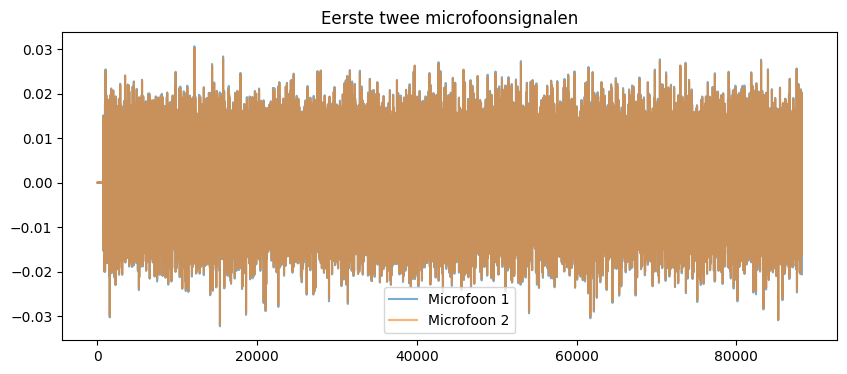

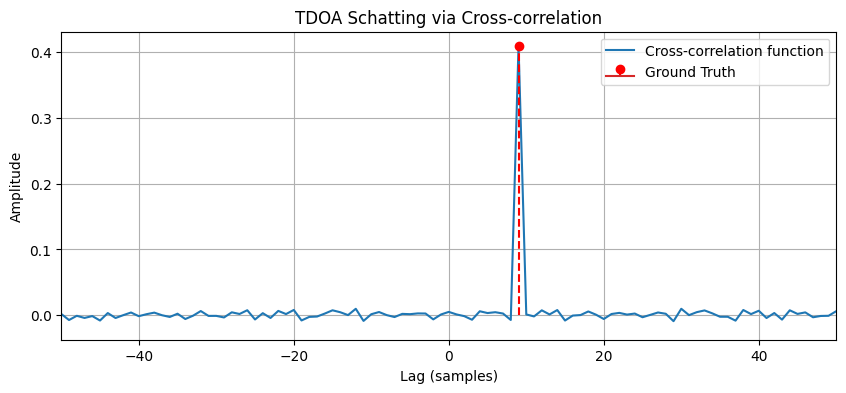

Ground Truth TDOA: 9 samples
Estimated TDOA:    9 samples
Error:             0 samples

 De error is 0.


In [19]:

try:
    path_to_rirs = "rirs"
    rir_file = select_latest_rir(path_to_rirs)
    acousticScenario = load_rirs(rir_file)
    print(f"Scenario geladen: {rir_file}")
    



    noise_files = [os.path.join("sound_files", "White_noise1.wav")]
    
 
    est, gt = TDOA_corr(acousticScenario, noise_files, segment_duration=0.2)
    

    print(f"\n De error is {est - gt}.")

except Exception as e:
    print(f"Er is iets misgegaan bij het laden of uitvoeren: {e}")

In [4]:
def DOA_corr(acoustic_scenario, noise_filenames, segment_duration):
    fs = acoustic_scenario.fs
    c = acoustic_scenario.c
    pos1 = acoustic_scenario.micPos[0]
    pos2 = acoustic_scenario.micPos[1]
    
    d = np.sqrt(np.sum((pos1 - pos2)**2))    
    
  
    mics, _, _ = create_micsigs(acoustic_scenario, noise_filenames, [], duration=2.0)
    

    N = int(segment_duration * fs)
    sig1 = mics[:N, 0]
    sig2 = mics[:N, 1]

    corr = signal.correlate(sig2, sig1, mode='full')

    lags = np.arange(-N + 1, N)
    

    estimated_tdoa = lags[np.argmax(corr)]

    tau = -estimated_tdoa / fs #samples naar sec

    cos_theta = (tau * c) / d
    #cos_theta = np.clip(cos_theta, -1.0, 1.0) #niet buiten domein door afrondingsfouten
    
    theta_rad = np.arccos(cos_theta)
    theta_deg = np.degrees(theta_rad)
    

    DOAestAll = [theta_deg]
    
    print(f"Geschatte TDOA: {estimated_tdoa} samples")
    print(f"Geschatte DOA:  {theta_deg:.2f} graden")
    
    return DOAestAll

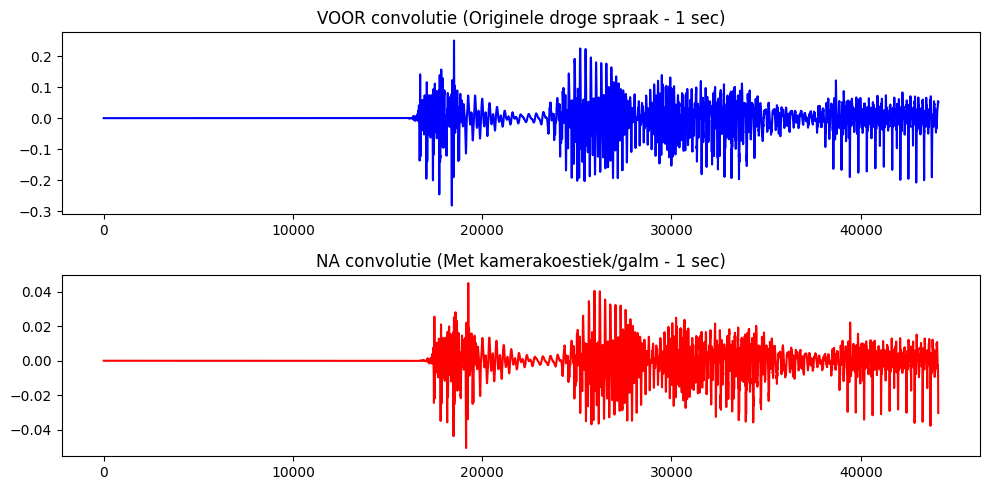

INFO: Ruis-verwerking overgeslagen (geen bestanden of geen ruis-RIRs gevonden).
Geschatte TDOA: 9 samples
Geschatte DOA:  133.94 graden


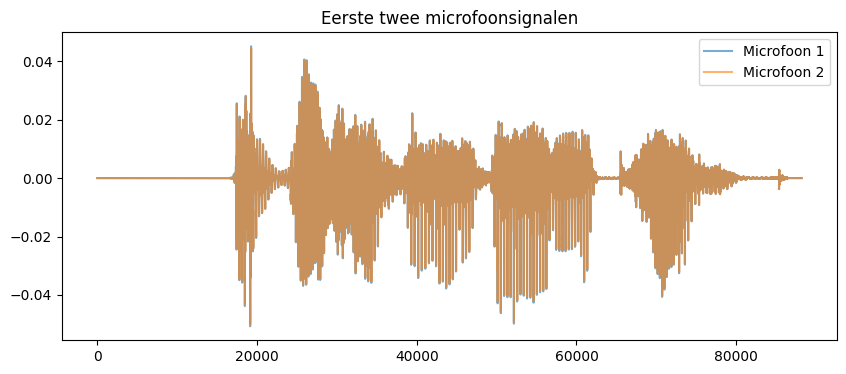

In [5]:

try:
    path_to_rirs = "rirs"
    rir_file = select_latest_rir(path_to_rirs)
    asc_44k = load_rirs(rir_file)



    speech_files = [os.path.join("sound_files", "speech1.wav")]


    DOAestAll = DOA_corr(asc_44k, speech_files, segment_duration=0.5)





except Exception as e:
    print(f"Fout bij uitvoeren: {e}")

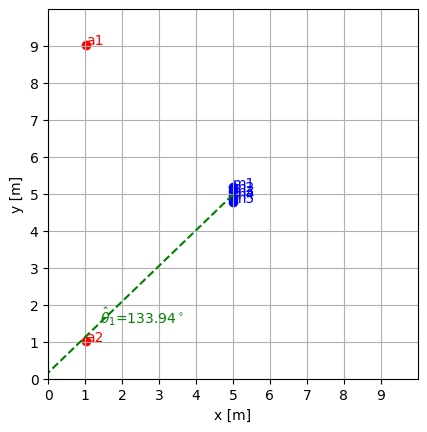

In [6]:

from package import check_plot_tdoas 


doa_in_rad = [theta * np.pi / 180 for theta in DOAestAll]


fig = check_plot_tdoas(
    doaEstTarget=doa_in_rad, 
    doaEstAll=doa_in_rad, 
    asc=acousticScenario
)

# 4. Toon de plot
plt.show()

PART 5

In [48]:
def TDOA_corr2(acoustic_scenario, noise_filenames, segment_duration, ref_mic=0, comp_mic=1):
    fs = acoustic_scenario.fs
    

    mics, _, _ = create_micsigs(acoustic_scenario, noise_filenames, [], duration=2.0)

    N = int(segment_duration * fs)
    sig1 = mics[:N, ref_mic]      
    sig2 = mics[:N, comp_mic]     

  
    corr = signal.correlate(sig2, sig1, mode='full')
    lags = np.arange(-N + 1, N)
    
    estimated_tdoa = lags[np.argmax(corr)]
    

    plt.figure(figsize=(10, 3))
    plt.plot(lags, corr)
    plt.title(f"Cross-correlation: Mic {ref_mic+1} vs Mic {comp_mic+1}") 
    plt.xlabel("Lag (samples)")
    plt.grid(True)
    
    
    plt.xlim([-100, 100]) 
    plt.show()

    return estimated_tdoa

INFO: Ruis-verwerking overgeslagen (geen bestanden of geen ruis-RIRs gevonden).


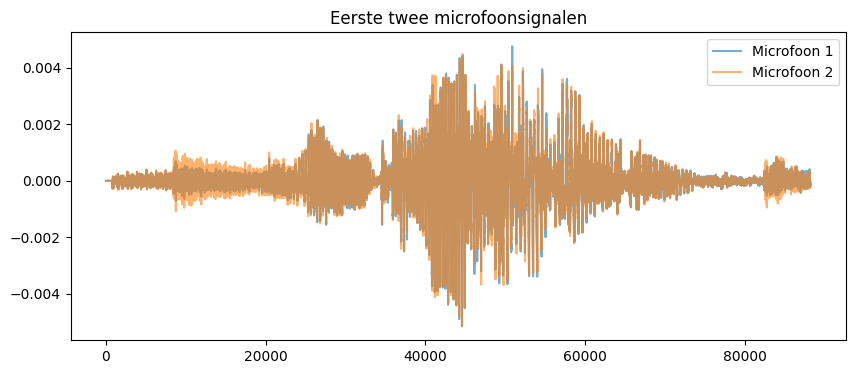

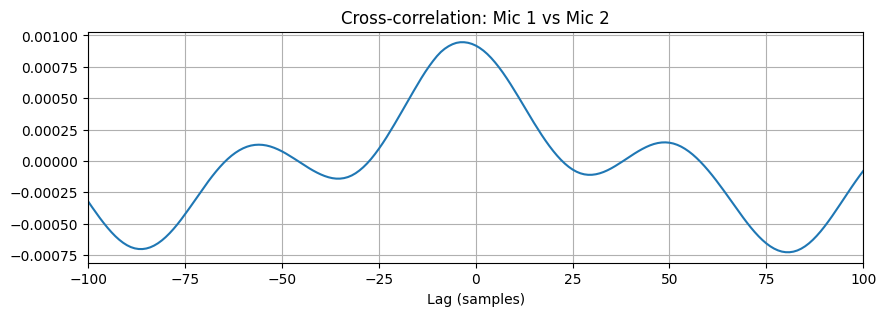

INFO: Ruis-verwerking overgeslagen (geen bestanden of geen ruis-RIRs gevonden).


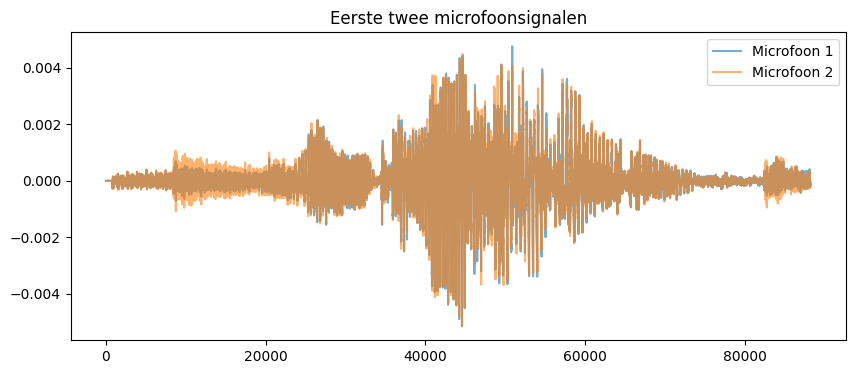

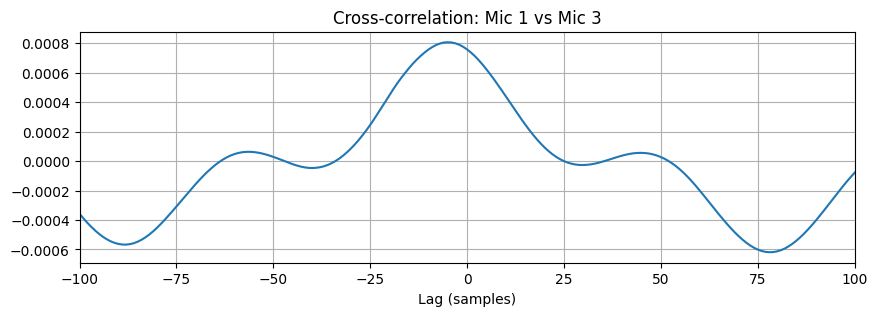

INFO: Ruis-verwerking overgeslagen (geen bestanden of geen ruis-RIRs gevonden).


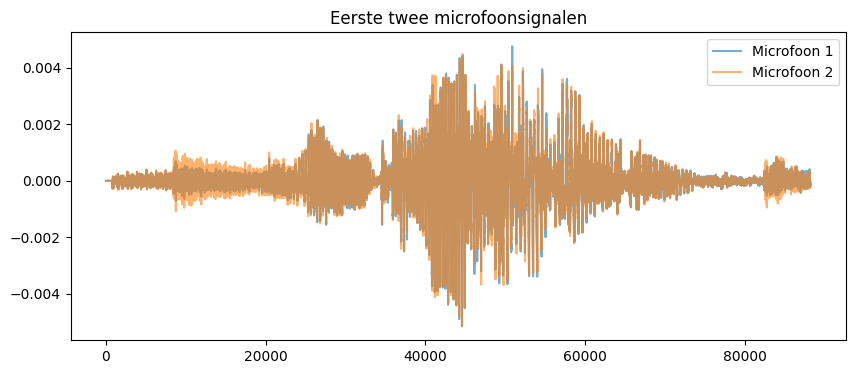

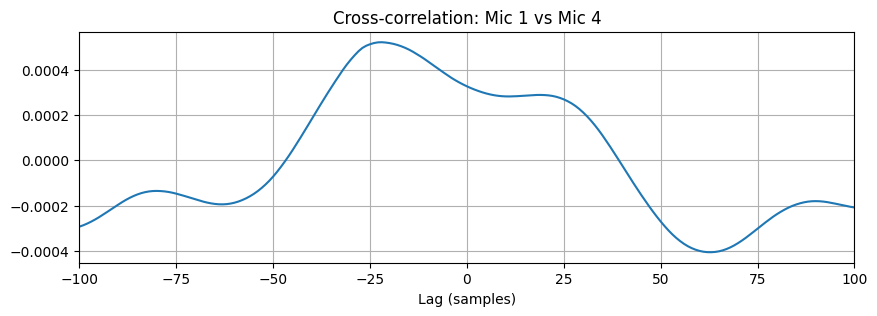

INFO: Ruis-verwerking overgeslagen (geen bestanden of geen ruis-RIRs gevonden).


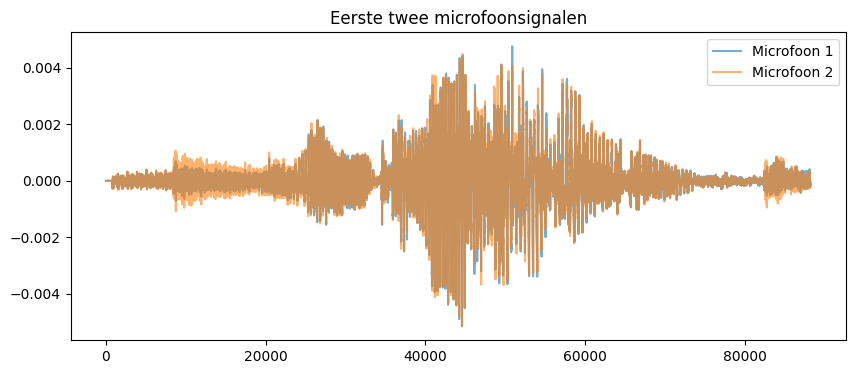

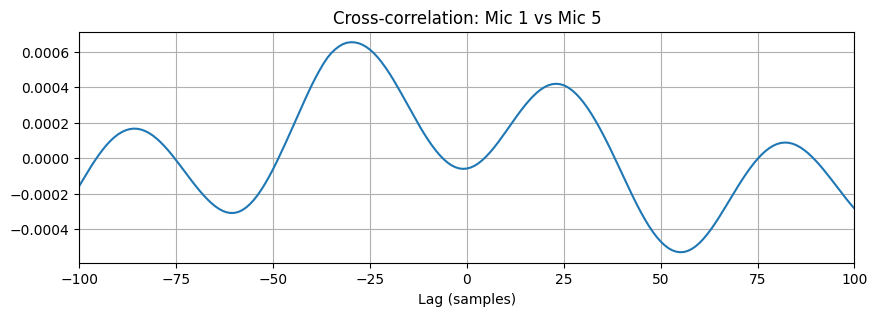

In [49]:

target_files = [
    os.path.join("sound_files", "part1_track1_dry.wav"), 
    os.path.join("sound_files", "part1_track2_dry.wav")
]


rir_file = select_latest_rir("rirs")
asc_multi = load_rirs(rir_file)

#alle paren met mic 1

for i in range(1, 5):
 
    TDOA_corr2(asc_multi, target_files, segment_duration=0.5, ref_mic=0, comp_mic=i)

INFO: Ruis-verwerking overgeslagen (geen bestanden of geen ruis-RIRs gevonden).

--- Paar Mic 1 & Mic 2 (d=0.10m) ---
Piek op lag 6: DOA = 117.6 graden
Piek op lag -1020: DOA = 0.0 graden


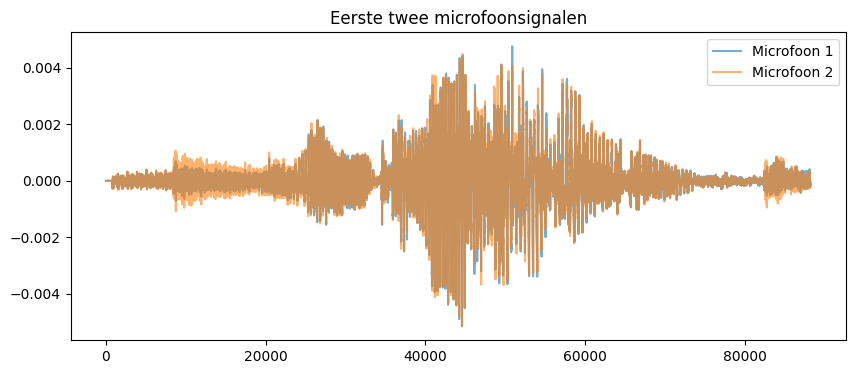

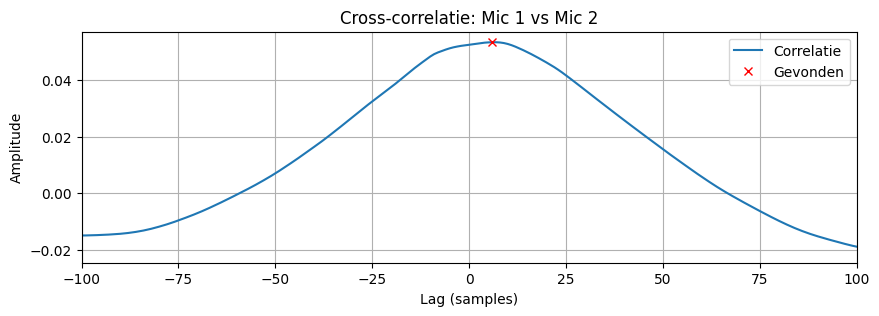


--- Paar Mic 1 & Mic 3 (d=0.20m) ---
Piek op lag 13: DOA = 120.1 graden
Piek op lag -1013: DOA = 0.0 graden


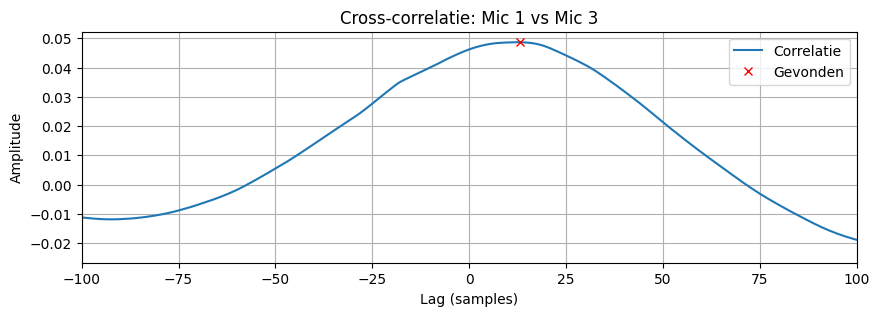


--- Paar Mic 1 & Mic 4 (d=0.30m) ---
Piek op lag 24: DOA = 128.1 graden
Piek op lag -1004: DOA = 0.0 graden


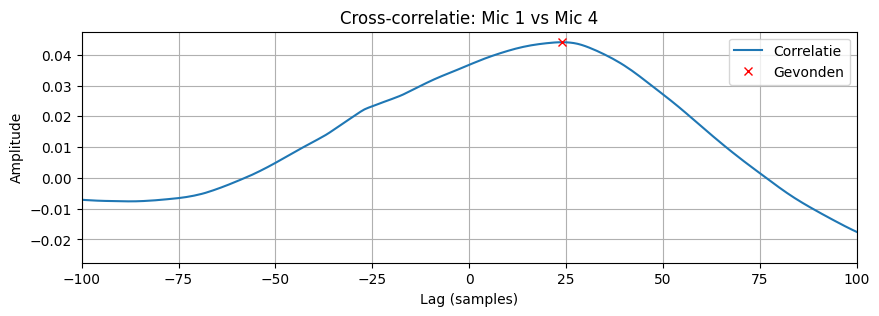


--- Paar Mic 1 & Mic 5 (d=0.40m) ---
Piek op lag 32: DOA = 128.1 graden
Piek op lag 396: DOA = 180.0 graden


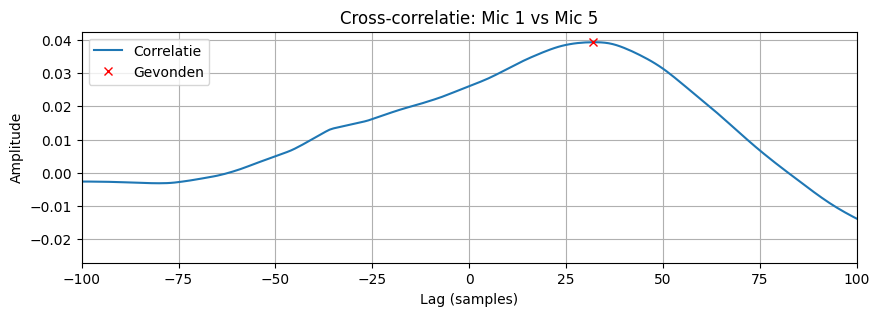


--- Paar Mic 2 & Mic 3 (d=0.10m) ---
Piek op lag 5: DOA = 112.7 graden
Piek op lag -1018: DOA = 0.0 graden


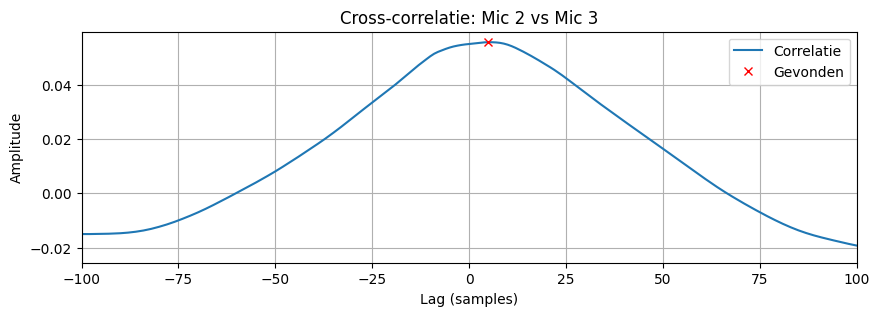


--- Paar Mic 2 & Mic 4 (d=0.20m) ---
Piek op lag 13: DOA = 120.1 graden
Piek op lag -1015: DOA = 0.0 graden


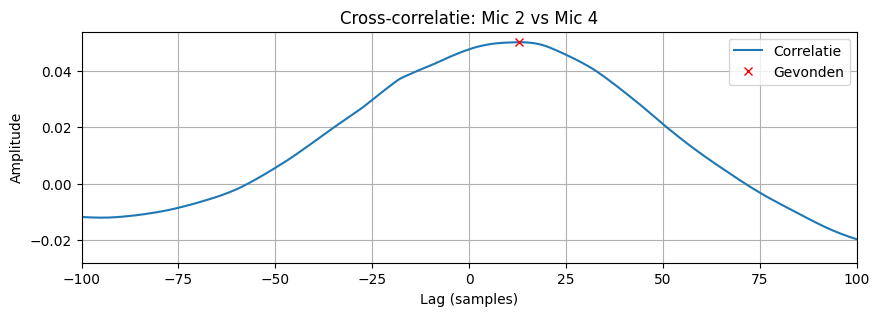


--- Paar Mic 2 & Mic 5 (d=0.30m) ---
Piek op lag 24: DOA = 128.1 graden
Piek op lag -1009: DOA = 0.0 graden


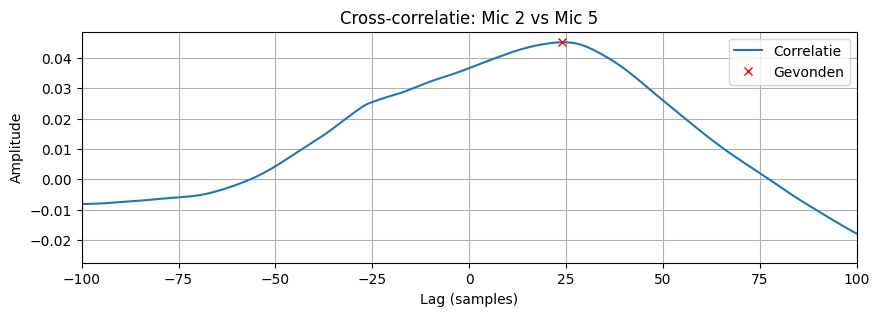


--- Paar Mic 3 & Mic 4 (d=0.10m) ---
Piek op lag 6: DOA = 117.6 graden
Piek op lag -1021: DOA = 0.0 graden


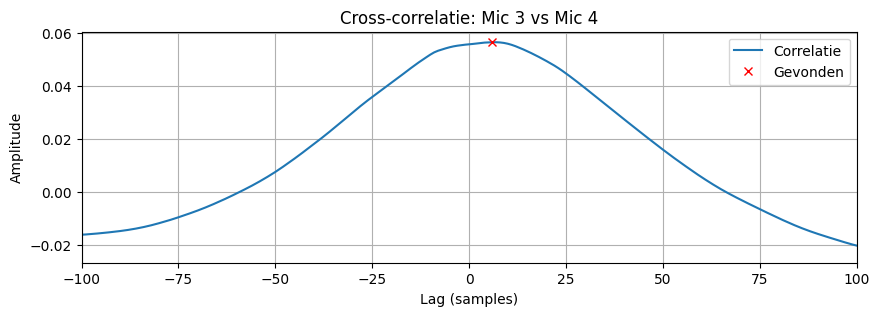


--- Paar Mic 3 & Mic 5 (d=0.20m) ---
Piek op lag 14: DOA = 122.7 graden
Piek op lag -1017: DOA = 0.0 graden


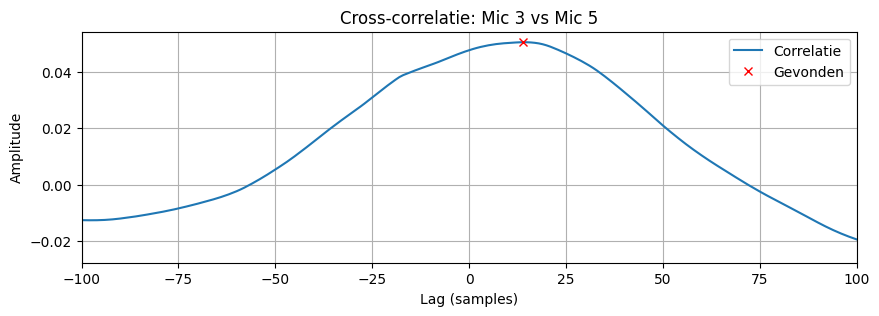


--- Paar Mic 4 & Mic 5 (d=0.10m) ---
Piek op lag 6: DOA = 117.6 graden
Piek op lag -1019: DOA = 0.0 graden


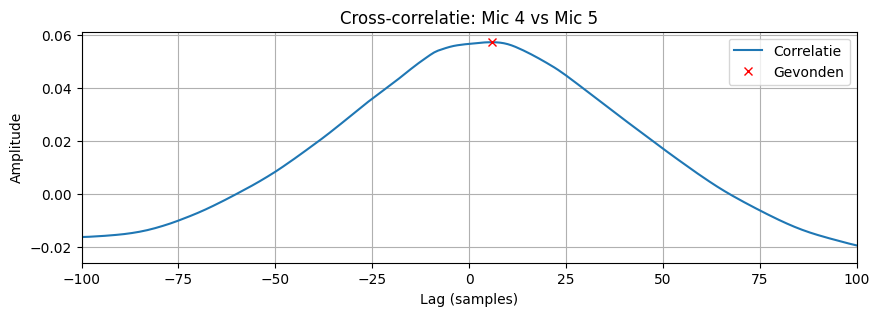

In [55]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import find_peaks


rir_file = select_latest_rir("rirs") 
asc_multi = load_rirs(rir_file)


target_files = [
    os.path.join("sound_files", "part1_track1_dry.wav"), 
    os.path.join("sound_files", "part1_track2_dry.wav")
]


mics, _, _ = create_micsigs(asc_multi, target_files, [], duration=2.0)

fs = asc_multi.fs
c = 340
num_mics = mics.shape[1] 



num_sources = asc_multi.audioPos.shape[0]


for i in range(num_mics):
    for j in range(i + 1, num_mics):
        
   
        sig_ref = mics[:, i]
        sig_comp = mics[:, j] 

     
        corr = signal.correlate(sig_comp, sig_ref, mode='full')
        lags = signal.correlation_lags(len(sig_ref), len(sig_comp))
        

        peak_indices, _ = find_peaks(corr, height=0.2*np.max(corr), distance=5)
        

        sorted_peaks = peak_indices[np.argsort(corr[peak_indices])[::-1]]
        top_peaks = sorted_peaks[:num_sources]

        pos_i = asc_multi.micPos[i]
        pos_j = asc_multi.micPos[j]
        d_ij = np.sqrt(np.sum((pos_i - pos_j)**2))
        
        print(f"\n--- Paar Mic {i+1} & Mic {j+1} (d={d_ij:.2f}m) ---")
        
        found_angles = []
        for p_idx in top_peaks:
            lag = lags[p_idx]
            
           
            tau = -lag / fs 
            val = (tau * c) / d_ij
            
            
            val = np.clip(val, -1.0, 1.0)
            theta = np.degrees(np.arccos(val))
            found_angles.append(theta)
            
            print(f"Piek op lag {lag}: DOA = {theta:.1f} graden")

    
        plt.figure(figsize=(10, 3))
        plt.plot(lags, corr, label='Correlatie')
      
        plt.plot(lags[top_peaks], corr[top_peaks], "rx", label='Gevonden')
        
        plt.title(f"Cross-correlatie: Mic {i+1} vs Mic {j+1}")
        plt.xlabel("Lag (samples)")
        plt.ylabel("Amplitude")
        plt.legend()
        plt.grid(True)
        plt.xlim([-100, 100]) 
        plt.show()

met reverb, fysieke mogelijk, autocorrelatie signalen checken 

Bij gebruik van standaard kruiscorrelatie op spraaksignalen is de resolutie onvoldoende om twee bronnen te onderscheiden. De lage frequenties zorgen voor brede correlatiepieken die samensmelten (constructieve interferentie), waardoor het algoritme slechts één dominante (gemiddelde) aankomstrichting detecteert binnen de fysieke limiet.

INFO: Ruis-verwerking overgeslagen (geen bestanden of geen ruis-RIRs gevonden).

--- Paar Mic 1 & Mic 2 (d=0.10m, Max lag=15) ---
Geldige Piek op lag 6: DOA = 117.6 graden


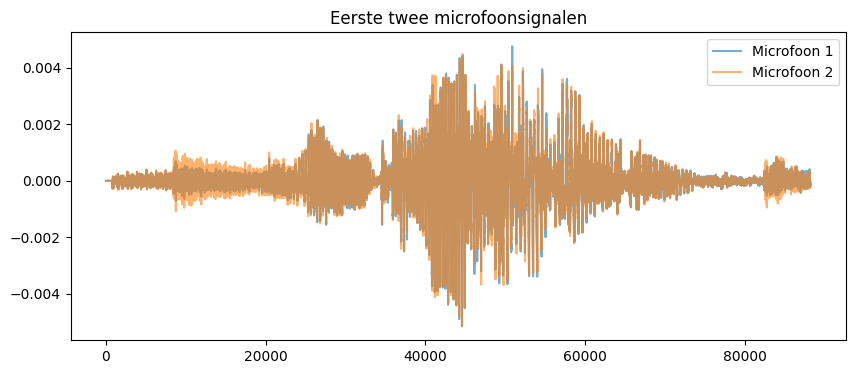

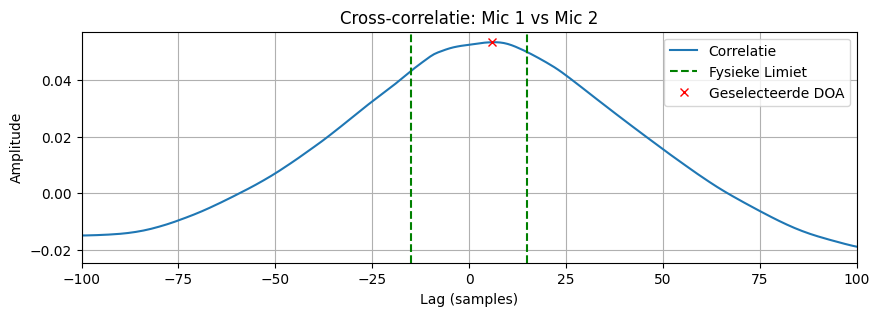


--- Paar Mic 1 & Mic 3 (d=0.20m, Max lag=28) ---
Geldige Piek op lag 13: DOA = 120.1 graden


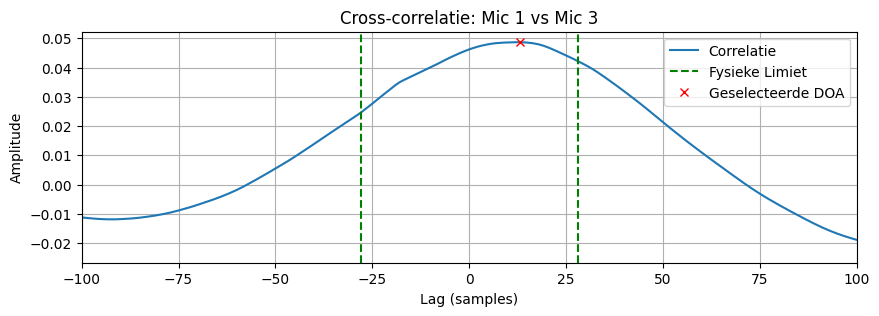


--- Paar Mic 1 & Mic 4 (d=0.30m, Max lag=41) ---
Geldige Piek op lag 24: DOA = 128.1 graden


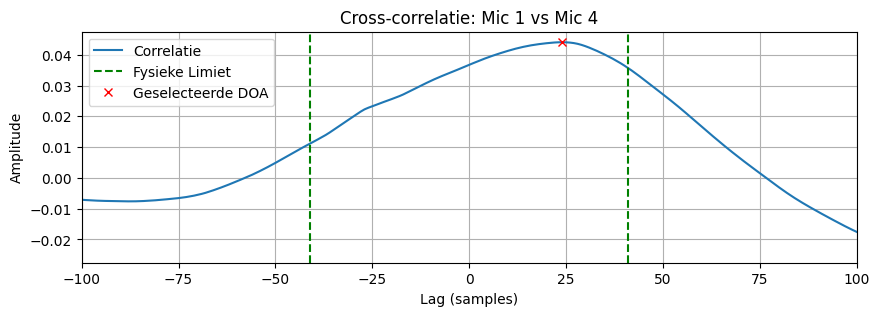


--- Paar Mic 1 & Mic 5 (d=0.40m, Max lag=54) ---
Geldige Piek op lag 32: DOA = 128.1 graden


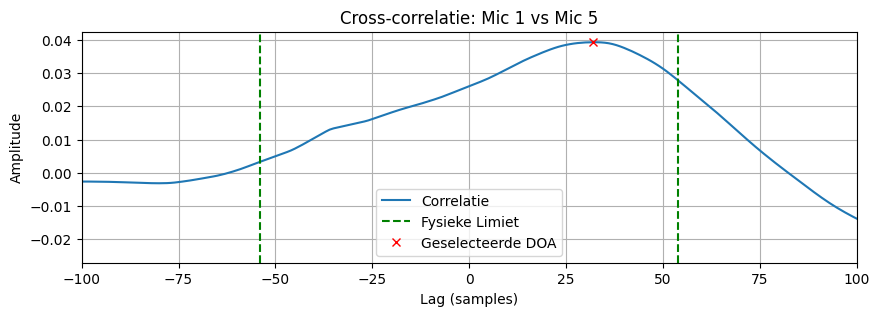


--- Paar Mic 2 & Mic 3 (d=0.10m, Max lag=15) ---
Geldige Piek op lag 5: DOA = 112.7 graden


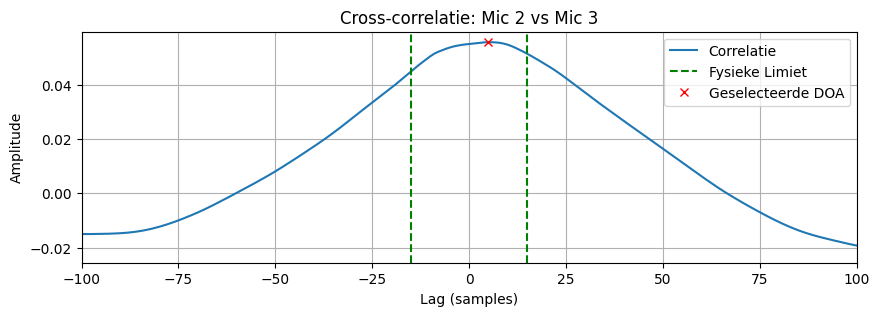


--- Paar Mic 2 & Mic 4 (d=0.20m, Max lag=28) ---
Geldige Piek op lag 13: DOA = 120.1 graden


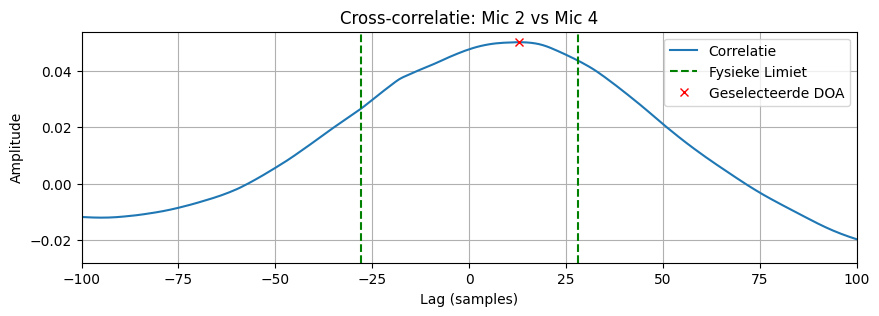


--- Paar Mic 2 & Mic 5 (d=0.30m, Max lag=41) ---
Geldige Piek op lag 24: DOA = 128.1 graden


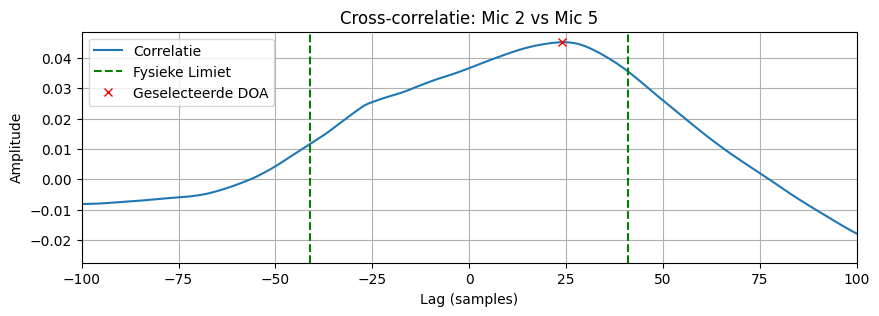


--- Paar Mic 3 & Mic 4 (d=0.10m, Max lag=15) ---
Geldige Piek op lag 6: DOA = 117.6 graden


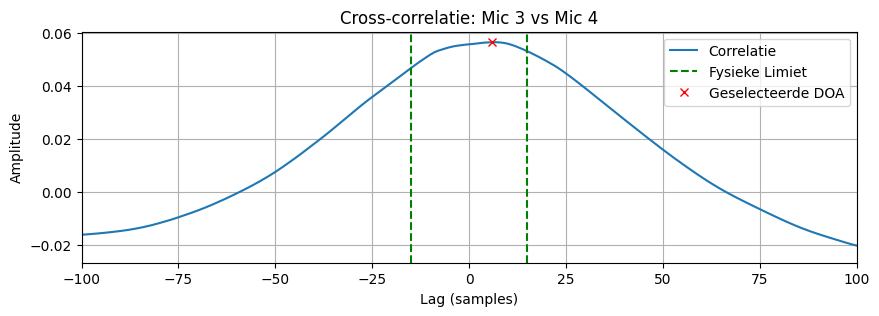


--- Paar Mic 3 & Mic 5 (d=0.20m, Max lag=28) ---
Geldige Piek op lag 14: DOA = 122.7 graden


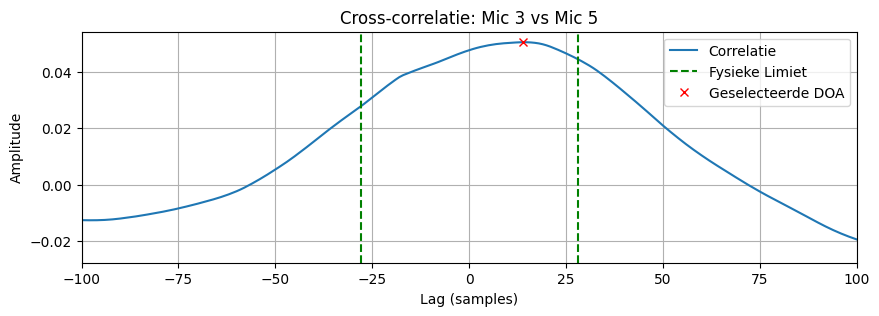


--- Paar Mic 4 & Mic 5 (d=0.10m, Max lag=15) ---
Geldige Piek op lag 6: DOA = 117.6 graden


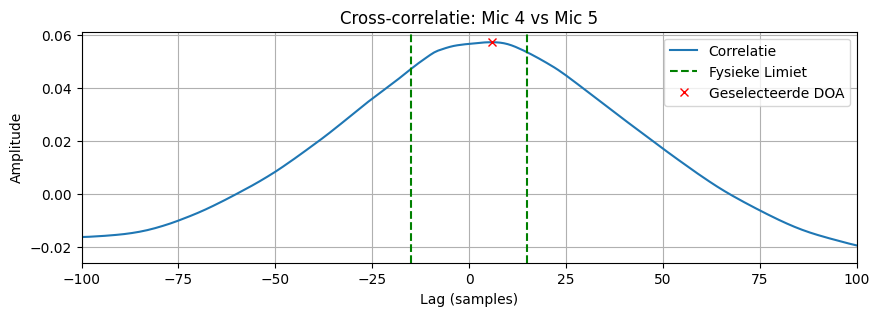

In [56]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import find_peaks


rir_file = select_latest_rir("rirs") 
asc_multi = load_rirs(rir_file)



target_files = [
    os.path.join("sound_files", "part1_track1_dry.wav"), 
    os.path.join("sound_files", "part1_track2_dry.wav")
]


mics, _, _ = create_micsigs(asc_multi, target_files, [], duration=2.0)


fs = asc_multi.fs
c = asc_multi.c
num_mics = mics.shape[1] 



num_sources = asc_multi.audioPos.shape[0]



for i in range(num_mics):
    for j in range(i + 1, num_mics):
        
        sig_ref = mics[:, i]
        sig_comp = mics[:, j] 
        #start = int(0.5 * fs) 
        #end = int(1.0 * fs)
        #sig_ref = mics[start:end, i]
        #sig_comp = mics[start:end, j]
   

        corr = signal.correlate(sig_comp, sig_ref, mode='full')
        lags = signal.correlation_lags(len(sig_ref), len(sig_comp))
        
    
        pos_i = asc_multi.micPos[i]
        pos_j = asc_multi.micPos[j]
        d_ij = np.sqrt(np.sum((pos_i - pos_j)**2))
        
        # Maximaal mogelijke vertraging in samples (+3 marge voor afronding)
        max_lag_samples = int((d_ij / c) * fs) + 3

  
        peak_indices, _ = find_peaks(corr, height=0.1*np.max(corr), distance=5)
        
    
        sorted_peak_indices = peak_indices[np.argsort(corr[peak_indices])[::-1]]
        
   #is piek fysiek mogelijk?
        valid_peaks = []
        for idx in sorted_peak_indices:
            lag = lags[idx]
     
            if abs(lag) <= max_lag_samples:
                valid_peaks.append(idx)
            
         #genoeg bronnen 
            if len(valid_peaks) == num_sources:
                break
        

        top_peaks = valid_peaks

        print(f"\n--- Paar Mic {i+1} & Mic {j+1} (d={d_ij:.2f}m, Max lag={max_lag_samples}) ---")
        
        found_angles = []
        for p_idx in top_peaks:
            lag = lags[p_idx]
            
            tau = -lag / fs 
            val = (tau * c) / d_ij
            
            
            #val = np.clip(val, -1.0, 1.0)
            theta = np.degrees(np.arccos(val))
            found_angles.append(theta)
            
            print(f"Geldige Piek op lag {lag}: DOA = {theta:.1f} graden")

       
        plt.figure(figsize=(10, 3))
        plt.plot(lags, corr, label='Correlatie')
        
       
        plt.axvline(x=-max_lag_samples, color='g', linestyle='--', label='Fysieke Limiet')
        plt.axvline(x=max_lag_samples, color='g', linestyle='--')

        if len(top_peaks) > 0:
            plt.plot(lags[top_peaks], corr[top_peaks], "rx", label='Geselecteerde DOA')
        
        plt.title(f"Cross-correlatie: Mic {i+1} vs Mic {j+1}")
        plt.xlabel("Lag (samples)")
        plt.ylabel("Amplitude")
        plt.legend()
        plt.grid(True)
        plt.xlim([-100, 100]) 
        plt.show()

part 6

In [ ]:
import os
import numpy as np
import soundfile as sf
from scipy import signal
import IPython.display as ipd

# --- CONFIGURATIE ---
# Op basis van jouw screenshot:
base_folder = os.path.join("sound_files", "head_mounted_rirs")
dry_signal_path = os.path.join("sound_files", "part1_track1_dry.wav")

# De mappenlijst op basis van jouw screenshot
# We voegen 's0' toe als die bestaat, anders kun je deze lijst aanpassen
folder_names = ["s-90", "s-60", "s-30", "s30", "s60", "s90"] 

fs_sim = 44100
c = 340

# Afstanden uit de opdracht
d_ear = 0.013    # 1.3 cm tussen yR1-yR2 en yL1-yL2
d_front = 0.215  # 21.5 cm tussen yL1-yR1

# Laad het droge bronsignaal
dry_sig, fs_src = sf.read(dry_signal_path)

def get_doa(sig1, sig2, d, fs):
    corr = signal.correlate(sig2, sig1, mode='full')
    lags = signal.correlation_lags(len(sig1), len(sig2))
    
    max_lag = int((d / c) * fs) + 1
    mask = (lags >= -max_lag) & (lags <= max_lag)
    
    if not np.any(mask): return np.nan
    
    masked_corr = corr.copy()
    masked_corr[~mask] = np.min(corr)
    
    peak_idx = np.argmax(masked_corr)
    lag = lags[peak_idx]
    
    tau = -lag / fs
    theta = np.degrees(np.arccos(np.clip((tau * c) / d, -1.0, 1.0)))
    return theta

# --- ANALYSE LOOP ---
print(f"{'Map':<10} | {'Right (1.3cm)':<15} | {'Left (1.3cm)':<15} | {'Front (21.5cm)':<15}")
print("-" * 70)

for folder in folder_names:
    path = os.path.join(base_folder, folder)
    
    try:
        # Laden van de specifieke HMIR bestanden
        # Let op: ik gebruik de namen uit je screenshot (zonder spatie, met underscore)
        yL1_rir, _ = sf.read(os.path.join(path, "HMIR_L1.wav"))
        yL2_rir, _ = sf.read(os.path.join(path, "HMIR_L2.wav"))
        yR1_rir, _ = sf.read(os.path.join(path, "HMIR_R1.wav"))
        yR2_rir, _ = sf.read(os.path.join(path, "HMIR_R2.wav"))
        
        # Convolutie om de microfoonsignalen te maken
        yL1 = signal.fftconvolve(dry_sig, yL1_rir, mode='full')
        yL2 = signal.fftconvolve(dry_sig, yL2_rir, mode='full')
        yR1 = signal.fftconvolve(dry_sig, yR1_rir, mode='full')
        yR2 = signal.fftconvolve(dry_sig, yR2_rir, mode='full')
        
        # DOA schattingen
        doa_right = get_doa(yR1, yR2, d_ear, fs_sim)
        doa_left  = get_doa(yL1, yL2, d_ear, fs_sim)
        doa_front = get_doa(yL1, yR1, d_front, fs_sim)
        
        print(f"{folder:<10} | {doa_right:<15.1f} | {doa_left:<15.1f} | {doa_front:<15.1f}")
        
        # Binauraal luisteren voor s90 (als voorbeeld)
        if folder == "s90":
            print(f"\n--- Binauraal fragment voor {folder} ---")
            binaural = np.vstack((yL1, yR1)).T
            ipd.display(ipd.Audio(binaural.T, rate=fs_sim))
            print("-" * 70)
            
    except Exception as e:
        print(f"Fout bij map {folder}: {e}")

Map        | Right (1.3cm)   | Left (1.3cm)    | Front (21.5cm) 
----------------------------------------------------------------------
s-90       | 90.0            | 90.0            | 180.0          
s-60       | 90.0            | 126.4           | 165.5          
s-30       | 90.0            | 126.4           | 115.5          
s30        | 126.4           | 90.0            | 62.2           
s60        | 126.4           | 90.0            | 30.6           
